## Setup
* 4 x 4 code sample all errors in Pauli noise regimes
    * Low - less than $\frac{L - 1}{2}$
    * Medium - Between $\frac{L - 1}{2}$ and $L$ 
    * High - From $L$ to $L^2$
* Perform decoding process for each of these noise regimes, sampling many errors for each types of noise regime

## Other Action Items
* Weighted edges for graphs (negative log-likelihood)
    * CHECK OTHER JUPYTER NOTEBOOK
* Figuring out phenomenological & circuit-level

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from lib.stabilizer import measurement_gadgets, StabilizerCode, stabilizer_circuits
from lib.color_compass import *
from lib.decoder import checkmatrix,pL_from_checkmatrix
from lib.stim2pymatching import estimate_pL_noisy_graph
import stimcirq
from typing import *
from cirq.contrib.svg import SVGCircuit
import networkx as nx
import time
from tqdm import tqdm
import scipy.stats as ss
import pickle
from pymatching import Matching
from ldpc import bposd_decoder

%load_ext autoreload
%autoreload 2

In [3]:
class Lattice2D():
    """
    convention: 
    X coords extend vertically |
    Z coords extend horizontally --
    store the coloring as a list with values in {-1, 0, 1}
    
    Red  ~ -1 ~ Z-type cuts
    Blue ~ +1 ~ X-type cuts
    White ~ 0
    
    preallocate logical X and L as cuts accross the lattice
    """
    def __init__(self, dimX, dimZ):
        self.dimX = dimX
        self.dimZ = dimZ
        self.colors = [0] * (dimX-1)*(dimZ-1)
        self.stabs = bacon_shor_group(dimX, dimZ)
        self.gauge = bsgauge_group(dimX, dimZ)
        self.Lx = ''.join(['X']*dimX+['_']*dimX*(dimZ-1))
        self.Lz = ''.join((['Z']+['_']*(dimX-1))*dimZ)
        self.logicals = [self.Lx,self.Lz]
        
    def size(self):
        return self.dimX*self.dimZ
        
    def __str__(self):
        vertex_rows = []
        face_rows = []
        dimX = self.dimX
        dimZ = self.dimZ
        for i in range(dimX):
            vertex_string = ''
            for j in range(dimZ):
                vertex_string += str(i*dimZ + j).zfill(3)
                if (j != dimZ-1):
                    vertex_string += '---'
            vertex_rows.append(vertex_string)
                
        for i in range(dimX-1):
            face_string = ''
            for j in range(dimZ-1):
                if(self.colors[i*(dimZ-1) + j] == -1):
                    # face_string += ' | '+colored(' # ', 'red')
                    face_string += ' | ' + ' ░ '
                elif(self.colors[i*(dimZ-1) + j] == +1):
                    # face_string += ' | '+colored(' # ', 'blue')
                    face_string += ' | ' + ' ▓ '
                elif(self.colors[i*(dimZ-1) + j] == 0):
                    face_string += ' |    '
                else:
                    raise ValueError(f'Invalid color type {self.colors[i*dimZ+j]}')
                if j == dimZ-2:
                    face_string += ' |'
            face_rows.append(face_string)
        sout = ''
        for idx, row in enumerate(vertex_rows):
            sout += row +'\n'
            if idx != len(vertex_rows)-1:
                sout += face_rows[idx]+'\n'
        return sout
    
    def size(self):
        return self.dimX*self.dimZ
    
    def getG(self):
        return self.gauge[0]+self.gauge[1]
    
    def getGx(self):
        return self.gauge[0]
    
    def getGz(self):
        return self.gauge[1]
    
    def getS(self):
        return self.stabs[0]+self.stabs[1]
    
    def getSx(self):
        return self.stabs[0]
    
    def getSz(self):
        return self.stabs[1]
    
    def getDims(self):
        return (self.dimX, self.dimZ)
    
    def max_stab_number(self):
        return self.dimX*self.dimZ - 1
    
    def pcheckZ(self):
        """returns the Z parity check matrix"""
        return np.vstack([pauli2vector(s) for s in self.getSz()])
        
    def pcheckX(self):
        """returns the X parity check matrix"""
        return np.vstack([pauli2vector(s) for s in self.getSx()])
    
    def display(self, pauli):
        dimX = self.dimX
        dimZ = self.dimZ
        if (len(pauli) != dimX*dimZ):
            raise ValueError("Pauli string dimension mismatch with lattice size")
        sout = ''
        slist = list(pauli)
        for i in range(dimX):
            for j in range(dimZ):
                if slist[i*dimZ+j] == 'X':
                    sout += ' X '
                elif slist[i*dimZ+j] == 'Z':
                    sout += ' Z '
                else:
                    sout += '   '
                if (j != dimZ-1):
                    sout += '---'
            if (i != dimX -1):
                sout += '\n'
                sout += ' |    '*dimZ
            sout += '\n'
        print(sout)
        
    def color_lattice(self, colors):
        """
        replace color state with input and recalculate stab and gauge groups 
        """
        dimX = self.dimX-1
        dimZ = self.dimZ-1
        if(len(colors) != dimX*dimZ):
            raise ValueError("Color dimension mismatch with lattice size")
        
        self.stabs = bacon_shor_group(self.dimX, self.dimZ)
        self.gauge = bsgauge_group(self.dimX, self.dimZ)
        self.colors = colors
        
        
        for cidx, c in enumerate(colors):
            if c == -1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), -1)
            elif c == +1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), +1)
        
        
    def update_groups(self, coords, cut_type):
        """
        cut the stabilizer group by coloring the face with the given type
            AND
        update the gauge group 
    
        algo: 
        [0] pick the gauge operator g to cut around
        [1] find s \in S that has weight-2 overlap with g
        [2] divide that s 
        [3] update the gauge group 
        """
        (i, j) = coords
        dimX = self.dimX
        dimZ = self.dimZ
        [Sx, Sz] = self.getSx(), self.getSz()
        [Gx, Gz] = self.getGx(), self.getGz()
        
        if cut_type == -1:
            # -1 = red which is a Z-cut
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'Z'
            g[i*dimZ + j + 1] = 'Z'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sz):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two vertical parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, i+1):
                        s1[k*dimZ + j] = s[k*dimZ + j]
                        s1[k*dimZ + j+1] = s[k*dimZ + j+1]
                    for k in range(i+1, dimX):
                        s2[k*dimZ + j] = s[k*dimZ + j]
                        s2[k*dimZ + j+1] = s[k*dimZ + j+1]
                    del Sz[idx]
                    Sz.append(''.join(s1))
                    Sz.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[k + i*dimZ] = 'Z'
                gauge[k + i*dimZ + 1] = 'Z'
            Gx_new = []
            for g in Gx:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gx_new.append(g)
            Gx = Gx_new
                
        elif cut_type == +1:
            # +1 = blue that is a X-cut:
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'X'
            g[(i+1)*dimZ + j ] = 'X'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sx):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two horizontal parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, j+1):
                        s1[i*dimZ + k] = s[i*dimZ + k]
                        s1[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    for k in range(j+1, dimZ):
                        s2[i*dimZ + k] = s[i*dimZ + k]
                        s2[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    del Sx[idx]
                    Sx.append(''.join(s1))
                    Sx.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[k + i*dimZ] = 'X'
                gauge[k + (i+1)*dimZ] = 'X'
            Gz_new = []
            for g in Gz:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gz_new.append(g)
            Gz = Gz_new

        # update the groups
        self.stabs = [Sx, Sz]
        self.gauge = [Gx, Gz]
        
    def error_is_corrected(self, syn, l_1, l_2, l_op):
        #syn is a vector of syndrome measurements, which has the Sx syndrome bits first
        #l_1, l_2 are booleans corresponding to the logical operator measurement
        #l_op is the logical operator we're measuring, written as a stim Pauli string

        #also need to know the stabilizers to feed into the decoder

        #check parity of l_1, l_2. If they are the same: no logical error
        #If they are different: logical error
        logical_error = ((l_1+l_2) % 2 == 0)

        #syndrome measurement gives a syndrome s. Feed into decoder to get a correction operator c
        #set up decoder
        Sx = lat.getSx()
        Sz = lat.getSz()
        Hx = np.array([[1 if i != '_' else 0 for i in s] for s in Sx])
        Hz = np.array([[1 if i != '_' else 0 for i in s] for s in Sz])
        Mx = Matching(Hx)
        Mz = Matching(Hz)

        #obtain correction operator
        cx = Mx.decode(syn[:len(Sx)])
        cz = Mz.decode(syn[len(Sx):])
        Rx = stim.PauliString(''.join(['X' if i == 1 else '_' for i in cx]))
        Rz = stim.PauliString(''.join(['Z' if i == 1 else '_' for i in cz]))

        correction_op = Rx*Rz



        #check [c, l]
            #If l_1 = l_2 and [c, l_op] = 0, then the error has been properly corrected
            #in that c keeps the proper eigenstate
            #If l_1 = l_2 and [c, l_op] \neq 0, then the decoder takes the state out of the correct eigenstate
            #If l_1 \neq l_2 and [c,l_op] = 0, then the decoder fails to correct the error
            #If l_1 \neq l_2 and [c, l_op] \neq 0, then the decoder properly corrects the error
        is_corrected = (correction_op.commutes(l_op) != logical_error)

        return is_corrected

In [4]:
"""Sample a random Pauli error
    for now, I'll assume biased, symmetric, uncorrelated Pauli channel
"""
import random

def random_pauli(num_qubits : int, rates : list):
    assert rates[0] + rates[1] + rates[2] <= 1, "Error rate must not exceed 1"""
    paulis = []
    for i in range(num_qubits):
        x = random.uniform(0, 1)
        if x <= rates[0]: 
            paulis.append('X')
        elif x <= rates[0] + rates[1]:
            paulis.append('Y')
        elif x <= rates[0] + rates[1] + rates[2]:
            paulis.append('Z')
        else:
            paulis.append('_')
    return ''.join(paulis)

def random_pauli_of_weight(num_qubits : int, weight : int):
    assert weight < num_qubits, "Weight of error cannot exceed number of qubits"""
    indices = [i for i in range(num_qubits)]
    indices = np.random.choice(indices, weight)
    paulis = ['_'] * num_qubits 
    for index in indices:
        paulis[index] = np.random.choice(['X','Z','Y'])

    return ''.join(paulis)




def pcheck_clipZ(pcheck):
    """
    clip (remove) the 1st half of the parity check matrix
    """
    L = int(pcheck.shape[1]/2)
    return pcheck[:, L:]

def pcheck_clipX(pcheck):
    """
    clip (remove) the 2nd half of the parity check matrix
    """
    L = int(pcheck.shape[1]/2)
    return pcheck[:, :L]

### Low-Weight Errors

In [4]:
dim = 4

num_gauge_fixings = 100
num_errors = 2000
codespace_projection = np.zeros((num_gauge_fixings, num_errors))
logical_errors = np.zeros((num_gauge_fixings, num_errors))
uncorrected_logical_error_rate = np.zeros((num_gauge_fixings, num_errors))
for fix_num in tqdm(range(num_gauge_fixings)):
    lat = Lattice2D(dim, dim)
    coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
    lat.color_lattice(coloring)
    for num_error in range(num_errors):
        w = np.random.choice(list(range((dim - 1)//2)))
        E = random_pauli_of_weight(lat.size(), w)
        error = pauli2vector(E)
        pcheckX = lat.pcheckX()
        pcheckZ = lat.pcheckZ() 
        pcheck = np.vstack((pcheckX, pcheckZ))
        syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
        syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
        Hx = pcheck_clipX(pcheckX)
        Hz = pcheck_clipZ(pcheckZ)
        decodingX = Matching.from_check_matrix(Hx)
        decodingZ = Matching.from_check_matrix(Hz)
        recoveryX = decodingX.decode(syndromeZ)
        recoveryZ = decodingZ.decode(syndromeX)
        recovery = np.concatenate((recoveryZ, recoveryX))
        corrected_error = pauli2vector(E) + recovery % 2 

        if sum(twisted_product(pcheck, corrected_error)) > 0:
            codespace_projection[fix_num][num_error] = 1
        if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
            logical_errors[fix_num][num_error] = 1
        if (twisted_product(pauli2vector(lat.Lx), error) == 1) or (twisted_product(pauli2vector(lat.Lz), error) == 1):
            uncorrected_logical_error_rate[fix_num][num_error] = 1

assert(np.sum(codespace_projection) == 0)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:12<00:00,  1.32s/it]


In [5]:
logical_error_rates = []
for row in logical_errors:
    logical_error_rates.append(sum(row)/len(row))

Text(0.5, 1.0, 'Average Logical Error Rate over Uniformly-Random Gauge Fixings')

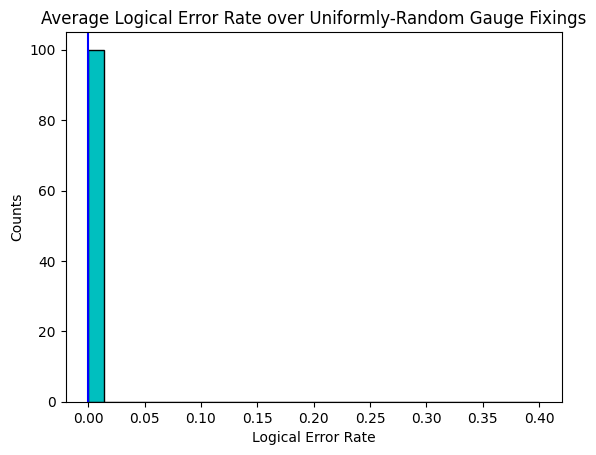

In [6]:
bins = np.linspace(0,0.4, 30)
plt.hist(logical_error_rates, bins, color='c', edgecolor='k')
plt.xlabel("Logical Error Rate")
plt.ylabel("Counts")
plt.axvline(np.mean(logical_error_rates), color='b')
plt.title("Average Logical Error Rate over Uniformly-Random Gauge Fixings")

### Medium-Weight Errors

In [7]:
dim = 4

num_gauge_fixings = 100
num_errors = 2000
codespace_projection = np.zeros((num_gauge_fixings, num_errors))
logical_errors = np.zeros((num_gauge_fixings, num_errors))
uncorrected_logical_error_rate = np.zeros((num_gauge_fixings, num_errors))
for fix_num in tqdm(range(num_gauge_fixings)):
    lat = Lattice2D(dim, dim)
    coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
    lat.color_lattice(coloring)
    for num_error in range(num_errors):
        w = np.random.choice(list(range((dim - 1)//2 + 1, (dim - 1)//2 + 2)))
        E = random_pauli_of_weight(lat.size(), w)
        error = pauli2vector(E)
        pcheckX = lat.pcheckX()
        pcheckZ = lat.pcheckZ() 
        pcheck = np.vstack((pcheckX, pcheckZ))
        syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
        syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
        Hx = pcheck_clipX(pcheckX)
        Hz = pcheck_clipZ(pcheckZ)
        decodingX = Matching.from_check_matrix(Hx)
        decodingZ = Matching.from_check_matrix(Hz)
        recoveryX = decodingX.decode(syndromeZ)
        recoveryZ = decodingZ.decode(syndromeX)
        recovery = np.concatenate((recoveryZ, recoveryX))
        corrected_error = pauli2vector(E) + recovery % 2 

        if sum(twisted_product(pcheck, corrected_error)) > 0:
            codespace_projection[fix_num][num_error] = 1
        if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
            logical_errors[fix_num][num_error] = 1
        if (twisted_product(pauli2vector(lat.Lx), error) == 1) or (twisted_product(pauli2vector(lat.Lz), error) == 1):
            uncorrected_logical_error_rate[fix_num][num_error] = 1

assert(np.sum(codespace_projection) == 0)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


In [43]:
logical_error_rates = []
for row in logical_errors:
    logical_error_rates.append(sum(row)/len(row))

0.24059000000000005


Text(0.5, 1.0, 'Average Logical Error Rate over Uniformly-Random Gauge Fixings')

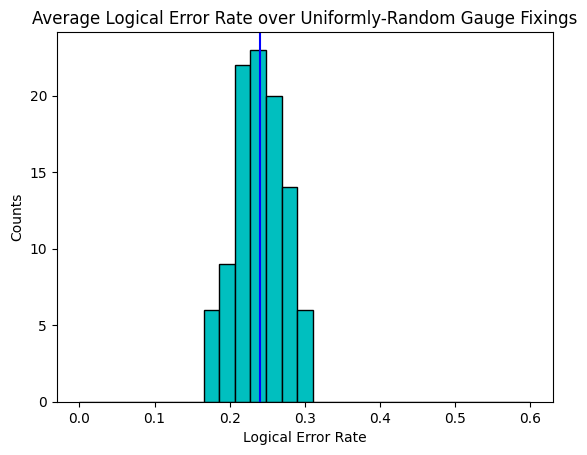

In [44]:
bins = np.linspace(0,0.6, 30)
plt.hist(logical_error_rates, bins, color='c', edgecolor='k')
plt.xlabel("Logical Error Rate")
plt.ylabel("Counts")
plt.axvline(np.mean(logical_error_rates), color='b')
print(np.mean(logical_error_rates))
plt.title("Average Logical Error Rate over Uniformly-Random Gauge Fixings")

In [31]:
dim = 4

num_gauge_fixings = 100
num_errors = 2000
codespace_projection = np.zeros((num_gauge_fixings, num_errors))
logical_errors = np.zeros((num_gauge_fixings, num_errors))
uncorrected_logical_error_rate = np.zeros((num_gauge_fixings, num_errors))
for fix_num in tqdm(range(num_gauge_fixings)):
    lat = Lattice2D(dim, dim)
    coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
    lat.color_lattice(coloring)
    for num_error in range(num_errors):
        w = np.random.choice(list(range(dim, (dim - 1)**2)))
        E = random_pauli_of_weight(lat.size(), w)
        error = pauli2vector(E)
        pcheckX = lat.pcheckX()
        pcheckZ = lat.pcheckZ() 
        pcheck = np.vstack((pcheckX, pcheckZ))
        syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
        syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
        Hx = pcheck_clipX(pcheckX)
        Hz = pcheck_clipZ(pcheckZ)
        decodingX = Matching.from_check_matrix(Hx)
        decodingZ = Matching.from_check_matrix(Hz)
        recoveryX = decodingX.decode(syndromeZ)
        recoveryZ = decodingZ.decode(syndromeX)
        recovery = np.concatenate((recoveryZ, recoveryX))
        corrected_error = pauli2vector(E) + recovery % 2 

        if sum(twisted_product(pcheck, corrected_error)) > 0:
            codespace_projection[fix_num][num_error] = 1
        if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
            logical_errors[fix_num][num_error] = 1
        if (twisted_product(pauli2vector(lat.Lx), error) == 1) or (twisted_product(pauli2vector(lat.Lz), error) == 1):
            uncorrected_logical_error_rate[fix_num][num_error] = 1

assert(np.sum(codespace_projection) == 0)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


In [32]:
logical_error_rates = []
for row in logical_errors:
    logical_error_rates.append(sum(row)/len(row))

Text(0.5, 1.0, 'Average Logical Error Rate over Uniformly-Random Gauge Fixings')

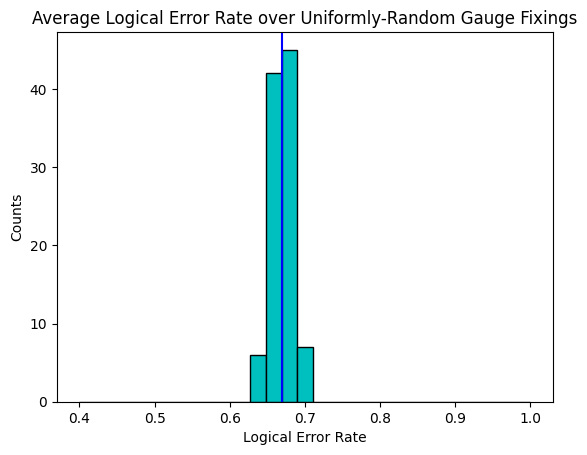

In [35]:
bins = np.linspace(0.4,1.0, 30)
plt.hist(logical_error_rates, bins, color='c', edgecolor='k')
plt.xlabel("Logical Error Rate")
plt.ylabel("Counts")
plt.axvline(np.mean(logical_error_rates), color='b')
plt.title("Average Logical Error Rate over Uniformly-Random Gauge Fixings")

### See how logical error rate changes for changing weight
* Want graph with weights on x-axis and logical error rate on z-axis

In [43]:
dim = 7
num_gauge_fixings = 100
num_errors = 500
codespace_projection = np.zeros((num_gauge_fixings, num_errors))
logical_errors = []
uncorrected_logical_error_rate = np.zeros((num_gauge_fixings, num_errors))
for fix_num in tqdm(range(num_gauge_fixings)):
    lat = Lattice2D(dim, dim)
    coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
    lat.color_lattice(coloring)
    for num_error in range(num_errors):
        w = np.random.choice(list(range((dim)**2//2)))
        E = random_pauli_of_weight(lat.size(), w)
        error = pauli2vector(E)
        pcheckX = lat.pcheckX()
        pcheckZ = lat.pcheckZ() 
        pcheck = np.vstack((pcheckX, pcheckZ))
        syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
        syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
        Hx = pcheck_clipX(pcheckX)
        Hz = pcheck_clipZ(pcheckZ)
        decodingX = Matching.from_check_matrix(Hx)
        decodingZ = Matching.from_check_matrix(Hz)
        recoveryX = decodingX.decode(syndromeZ)
        recoveryZ = decodingZ.decode(syndromeX)
        recovery = np.concatenate((recoveryZ, recoveryX))
        corrected_error = pauli2vector(E) + recovery % 2 

        if sum(twisted_product(pcheck, corrected_error)) > 0:
            codespace_projection[fix_num][num_error] = 1
        if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
            logical_errors.append((w, 1))
        else:
            logical_errors.append((w, 0))
        if (twisted_product(pauli2vector(lat.Lx), error) == 1) or (twisted_product(pauli2vector(lat.Lz), error) == 1):
            uncorrected_logical_error_rate[fix_num][num_error] = 1

assert(np.sum(codespace_projection) == 0)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


In [44]:
comp_logical_errors_dict = {k : [] for k in range((dim)**2//2)}
for weight_err in logical_errors:
    comp_logical_errors_dict[weight_err[0]].append(weight_err[1])


comp_logical_error_rates_dict = {k : np.sum(comp_logical_errors_dict[k])/len(comp_logical_errors_dict[k]) for k in comp_logical_errors_dict.keys()}

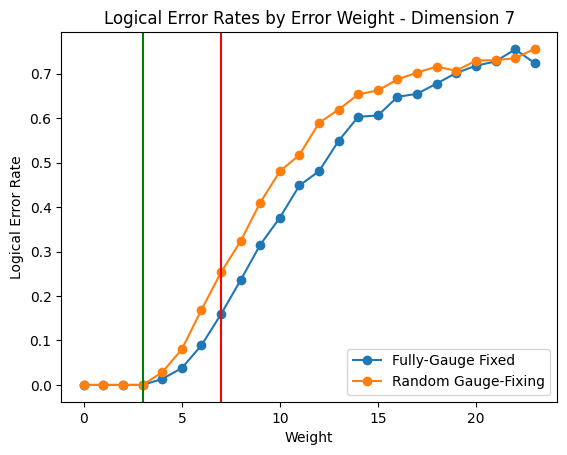

In [48]:
plt.figure()
plt.plot(logical_error_rates_dict.keys(), logical_error_rates_dict.values(), 'o-', label="Fully-Gauge Fixed")
plt.plot(comp_logical_error_rates_dict.keys(), comp_logical_error_rates_dict.values(), 'o-', label="Random Gauge-Fixing")
plt.title("Logical Error Rates by Error Weight - Dimension " + str(dim))
plt.axvline(7, color='red')
plt.axvline(3, color = 'green')
plt.xlabel("Weight")
plt.legend()
plt.ylabel("Logical Error Rate")
plt.show()

In [35]:
dim = 7
num_gauge_fixings = 100
num_errors = 500
codespace_projection = np.zeros((num_gauge_fixings, num_errors))
logical_errors = []
uncorrected_logical_error_rate = np.zeros((num_gauge_fixings, num_errors))
for fix_num in tqdm(range(num_gauge_fixings)):
    lat = Lattice2D(dim, dim)
    coloring = np.zeros(((dim - 1)**2,))
    locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
    for loc in locs:
        coloring[loc] = np.random.choice([-1,1])
    lat.color_lattice(coloring)
    for num_error in range(num_errors):
        w = np.random.choice(list(range((dim)**2//2)))
        E = random_pauli_of_weight(lat.size(), w)
        error = pauli2vector(E)
        pcheckX = lat.pcheckX()
        pcheckZ = lat.pcheckZ() 
        pcheck = np.vstack((pcheckX, pcheckZ))
        syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
        syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
        Hx = pcheck_clipX(pcheckX)
        Hz = pcheck_clipZ(pcheckZ)
        decodingX = Matching.from_check_matrix(Hx)
        decodingZ = Matching.from_check_matrix(Hz)
        recoveryX = decodingX.decode(syndromeZ)
        recoveryZ = decodingZ.decode(syndromeX)
        recovery = np.concatenate((recoveryZ, recoveryX))
        corrected_error = pauli2vector(E) + recovery % 2 

        if sum(twisted_product(pcheck, corrected_error)) > 0:
            codespace_projection[fix_num][num_error] = 1
        if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
            logical_errors.append((w, 1))
        else:
            logical_errors.append((w, 0))
        if (twisted_product(pauli2vector(lat.Lx), error) == 1) or (twisted_product(pauli2vector(lat.Lz), error) == 1):
            uncorrected_logical_error_rate[fix_num][num_error] = 1

assert(np.sum(codespace_projection) == 0)

100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


In [36]:
logical_errors_dict = {k : [] for k in range((dim)**2//2)}
for weight_err in logical_errors:
    logical_errors_dict[weight_err[0]].append(weight_err[1])


logical_error_rates_dict = {k : np.sum(logical_errors_dict[k])/len(logical_errors_dict[k]) for k in logical_errors_dict.keys()}

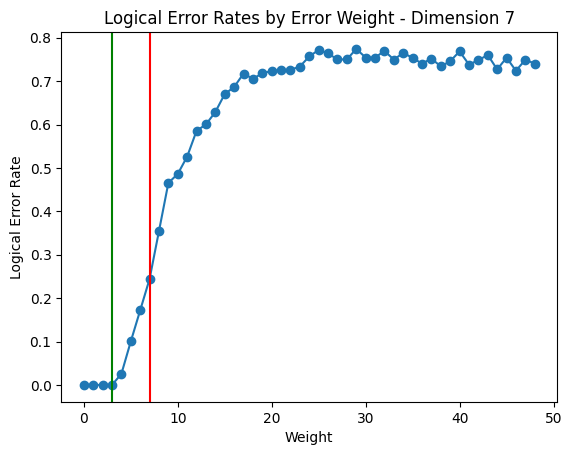

In [19]:
plt.figure()
plt.plot(logical_error_rates_dict.keys(), logical_error_rates_dict.values(), 'o-')
plt.title("Logical Error Rates by Error Weight - Dimension " + str(dim))
plt.axvline(7, color='red')
plt.axvline(3, color='green')
plt.xlabel("Weight")
plt.ylabel("Logical Error Rate")
plt.show()